In [1]:
# NOTICE!!!!
# replace 'E' in the equation with 'e' as sympy would treat 'E' as numerical value e.
##################

import sympy as sp
import pandas as pd

# Define custom operations using subclassing of sympy.Function
class Add(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x + y

class Sub(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x - y

class Mul(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x * y

class Div(sp.Function):
    @classmethod
    def eval(cls, x, y):
        try:
            result = sp.Piecewise(
                (1, sp.Eq(y, 0)),  # Return 1 if y is exactly zero
                (1, sp.Eq(y, sp.zoo)),  # Return 1 if y is exactly zero
                (x / y, True)           # Normal division otherwise
            )
            return result.simplify()  # Simplify to handle potential further issues
        except Exception as e:
            print(f"Division error: {e}")
            return 1000  # Return NaN on error
        
# Define the custom operations using subclassing of sympy.Function
class Div_for_visualization(sp.Function):
    @classmethod
    def eval(cls, x, y):
        # Use Piecewise to handle division by zero robustly
        return x / y

class Neg(sp.Function):
    @classmethod
    def eval(cls, x):
        return -x
    

# Update converter for sympify to recognize custom classes
converter = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div,
    'neg': Neg,
}

# Update converter for sympify to recognize custom classes
converter_vis = {
    'add': Add,
    'sub': Sub,
    'mul': Mul,
    'div': Div_for_visualization,
    'neg': Neg,
}

# Function to apply the equation to each row of the DataFrame
def apply_equation(row):
    # Replace variables in the expression with row data
    local_env = {
        'Pr': row['Pr'],
        'La': row['La'],
        'Gd': row['Gd'],
        'Nd': row['Nd'],
        'Ce': row['Ce'],
        'Sm': row['Sm'],
        'Y' : row['Y'],
        "EN": row['EN'],
        'R' : row['R'],
        'IE': row['IE'],
        'LAS': row['LAS'],
        'M' : row['M'],
        'e' : row['E'],
    }
    try:
        result = expr.subs(local_env)
        # Force numeric evaluation if the result is not numeric
        if isinstance(result, sp.Expr):  # Check if result is still a symbolic expression
            result = result.evalf()  # Evaluate numerically
        # if result == sp.zoo:
        #     result = 1
    except Exception as e:
        print(f"Error evaluating row: {local_env}")
        print(f"Error message: {str(e)}")
        result = None  # Optional: handle error case by assigning a default value or None
    return float(result)

    # print("Local Environment:", local_env)  # Debug: Print the local environment for a row
    # return expr.subs(local_env)

In [2]:
df = pd.read_excel('./all_rp750.xlsx')
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)

In [3]:
equ = "mul(0.482, add(M, add(div(div(sub(LAS, 4.128), sub(LAS, M)), Nd), add(sub(R, La), e))))"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_all'] = df.apply(apply_equation, axis=1)

equ = "add(div(sub(Ce, div(7.983, add(mul(sub(Gd, e), 4.263), Ce))), EN), EN)"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_La'] = df.apply(apply_equation, axis=1)

equ = "add(add(EN, div(sub(EN, R), mul(e, sub(4.966, Nd)))), div(sub(add(Pr, -1.646), EN), -3.185))"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_Gd'] = df.apply(apply_equation, axis=1)

equ = "mul(0.498, add(add(Ce, div(EN, add(R, div(div(-4.233, EN), sub(EN, Pr))))), e))"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_Nd'] = df.apply(apply_equation, axis=1)

equ = "sub(div(div(neg(e), div(mul(Gd, sub(e, La)), sub(Gd, La))), M), -6.986)"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_Ce'] = df.apply(apply_equation, axis=1)

equ = "add(div(sub(Sm, e), e), add(div(div(sub(Ce, 4.557), sub(R, Y)), Gd), e))"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_Sm'] = df.apply(apply_equation, axis=1)

equ = "add(div(sub(Gd, e), mul(mul(add(Gd, -3.690), neg(Gd)), sub(R, Y))), e)"
expr = sp.sympify(equ, locals=converter,evaluate=True)
# Apply the function to each row
df['pred_Y'] = df.apply(apply_equation, axis=1)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [5]:
df = df.apply(lambda x: round(x, 4) if x.dtype.kind in 'fc' else x)
# print(df)

# Convert to 0s and 1s based on condition
mask = (df.iloc[:,1:8] != 5.1907).astype(int)

# print("Transformed Mask:\n", mask)
inputs = df.iloc[:,-7:].astype(float)
# print(inputs)

inputs_masked = np.multiply(inputs.values, mask.values)
# print("Transformed Mask:\n", inputs_masked)

Index(['label', 'Pr', 'La', 'Gd', 'Nd', 'Ce', 'Sm', 'Y', 'EN', 'R', 'IE',
       'LAS', 'M', 'E', 'Rp-750', 'pred_all', 'pred_La', 'pred_Gd', 'pred_Nd',
       'pred_Ce', 'pred_Sm', 'pred_Y'],
      dtype='object')


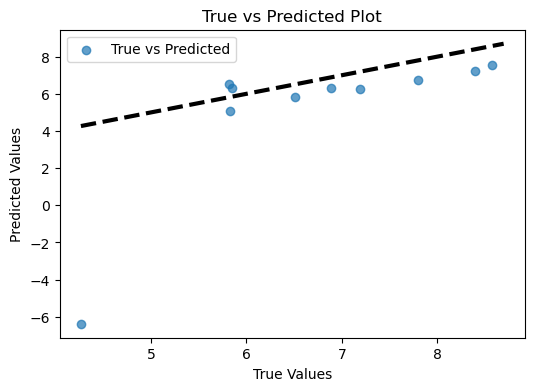

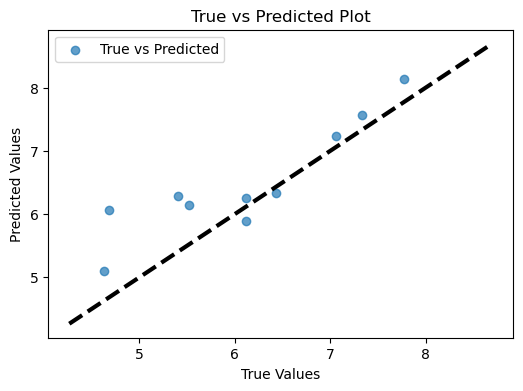

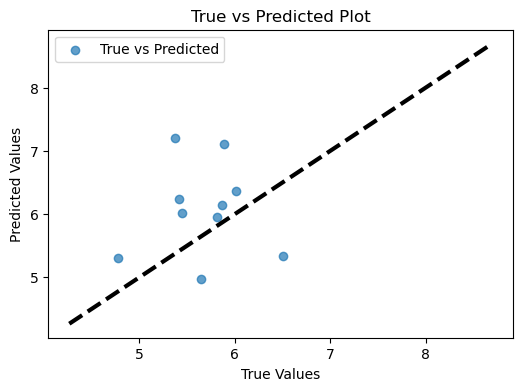

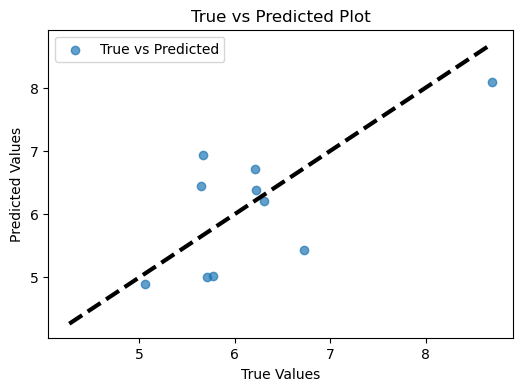

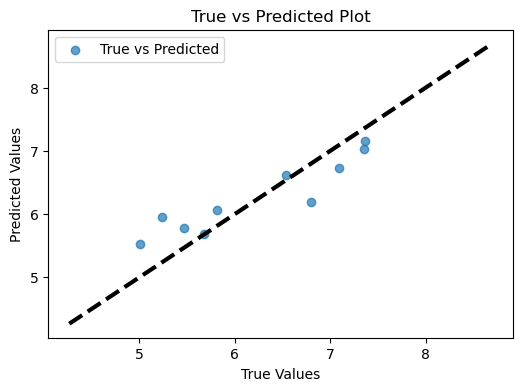

Fold 1: RMSE = 3.46104, R^2 = -6.43701
Fold 2: RMSE = 0.60195, R^2 = 0.65053
Fold 3: RMSE = 0.90527, R^2 = -3.24306
Fold 4: RMSE = 0.75055, R^2 = 0.36233
Fold 5: RMSE = 0.40204, R^2 = 0.77834
Mean RMSE: 1.2241706421463852
Mean R2: -1.577775238872237
Mean Coefficients: [0.25713983 0.17902308 0.02829549 0.52108328 0.32720728 0.09316963
 0.03422931]
Mean Intercept: -2.938277599422822


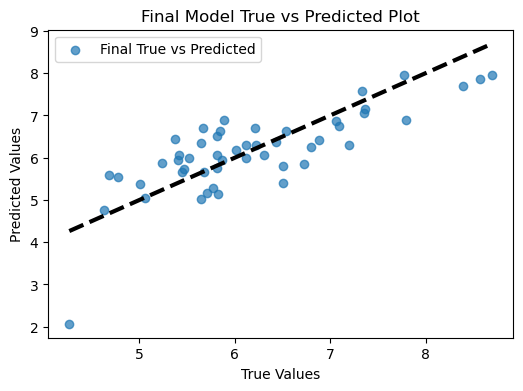

Final Model: RMSE = 0.65064, R^2 = 0.57667


In [6]:
print(df.columns)
X = df.iloc[:,-7:].values
Y = df['Rp-750'].values

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

coefs = []
intercepts = []
rmse = []
r2 = []

df_test_pred = {}

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate RMSE and R^2
    rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_ = r2_score(y_test, y_pred)
    rmse.append(rmse_)
    r2.append(r2_)
    
    # Store coefficients and intercepts
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Plotting true vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7, label='True vs Predicted')
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Plot')
    plt.legend()
    plt.show()

    # Create DataFrame from y_test and y_pred
    df_test_pred['Y_test%s'%i] = y_test
    df_test_pred['Y_pred%s'%i] = y_pred

# Calculate mean of coefficients and intercepts
mean_coef = np.mean(coefs, axis=0)
mean_intercept = np.mean(intercepts)
for i, (rmse_,r2_) in enumerate(zip(rmse,r2)):
    print(f"Fold {i+1}: RMSE = {rmse_:.5f}, R^2 = {r2_:.5f}")

print("Mean RMSE:", np.mean(rmse))
print("Mean R2:", np.mean(r2))
print("Mean Coefficients:", mean_coef)
print("Mean Intercept:", mean_intercept)

# Simulate final model prediction (as a simple matrix operation)
final_predictions = X.dot(mean_coef) + mean_intercept
final_rmse = np.sqrt(mean_squared_error(Y, final_predictions))
final_r2 = r2_score(Y, final_predictions)

# Plot final true vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(Y, final_predictions, alpha=0.7, label='Final True vs Predicted')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Final Model True vs Predicted Plot')
plt.legend()
plt.show()

print(f"Final Model: RMSE = {final_rmse:.5f}, R^2 = {final_r2:.5f}")

df_test_pred = pd.DataFrame(df_test_pred)
df_test_pred.to_excel("test_predictions_splits_no_gate.xlsx")

# Create DataFrame from y_test and y_pred
df_hybrid = {}
df_hybrid['Y_final'] = final_predictions
df_hybrid['Y'] = Y
df_hybrid = pd.DataFrame(df_hybrid)
df_hybrid.to_excel("test_predictions_hybrid_no_gate.xlsx")

[0.52911043 0.04426036 0.06269939 0.0650537  0.06024123 0.07824949
 0.02151406] 1.8985273264955245
RMSE: 0.6729868869267752
RMSE_original: 0.005832817360012441
R^2 score: 0.5470877401709808


c:\Users\Tobby\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


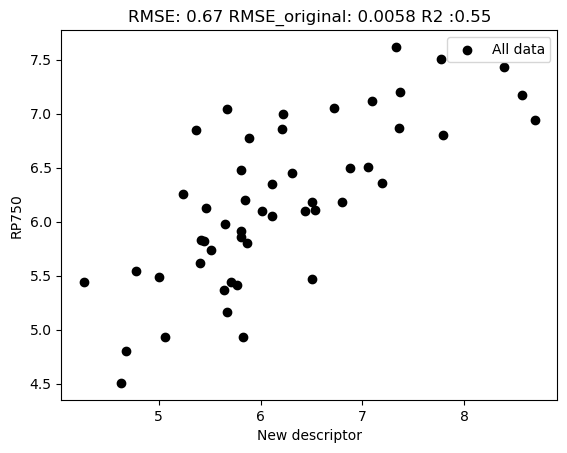

In [25]:
# Use the second column as X and the first as Y
X = inputs_masked
Y = df['Rp-750'].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X,Y)
print(model.coef_,model.intercept_)
# Predict on testing set
Y_pred = model.predict(X)

# Compute RMSE and R^2
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)
with open('../label_scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    mean = scaler.mean_[0]
    std = scaler.scale_[0]
Y_ = (Y-0.01-6.174468393277538)*std+mean
Y_pred_ = (Y_pred-0.01-6.174468393277538)*std+mean
rmse_ = np.sqrt(mean_squared_error(Y_, Y_pred_))

print(f"RMSE: {rmse}")
print(f"RMSE_original: {rmse_}")  
print(f"R^2 score: {r2}")

# Plotting true vs predicted values
plt.scatter(Y, Y_pred, color='black', label='All data')
plt.xlabel('New descriptor')
plt.ylabel('RP750')
plt.title(f'RMSE: {rmse:.2f} RMSE_original: {rmse_:.4f} R2 :{r2:.2f}')
plt.legend()
plt.show()

df["pred"] = Y_pred
# df.to_excel('all_rp750_final_pred.xlsx', index=False)

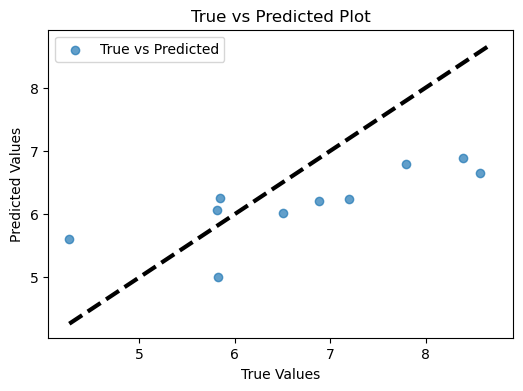

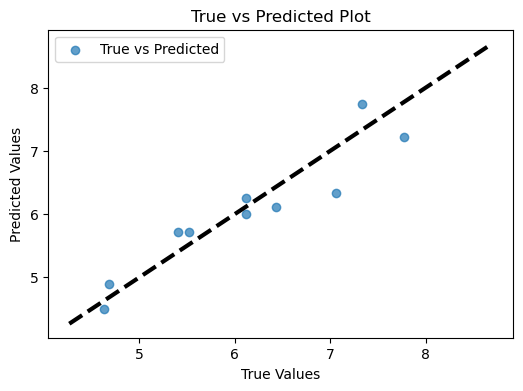

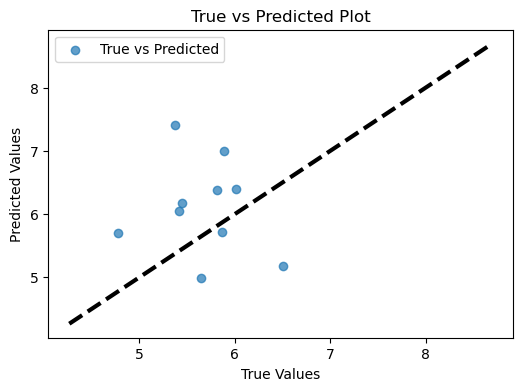

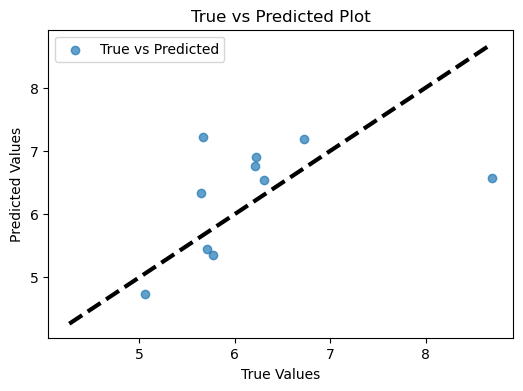

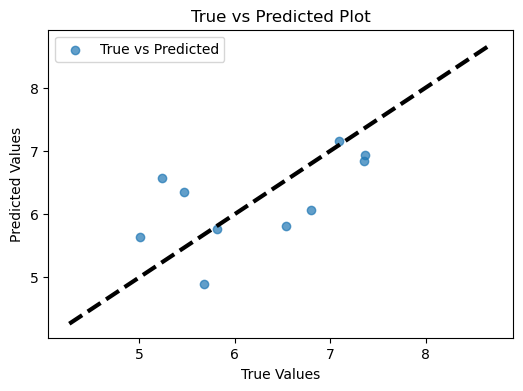

Fold 1: RMSE = 1.06406, R^2 = 0.29707
Fold 2: RMSE = 0.36325, R^2 = 0.87274
Fold 3: RMSE = 0.99371, R^2 = -4.11262
Fold 4: RMSE = 0.93784, R^2 = 0.00439
Fold 5: RMSE = 0.71303, R^2 = 0.30278
Mean RMSE: 0.814377434207944
Mean R2: -0.5271300976969162
Mean Coefficients: [0.53366074 0.03944002 0.06086653 0.06427795 0.05694237 0.07845619
 0.0229135 ]
Mean Intercept: 1.8960468810261488


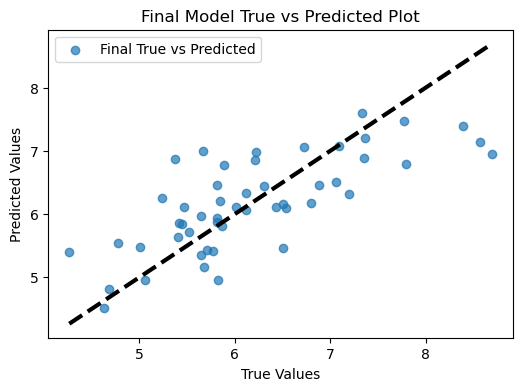

Final Model: RMSE = 0.67325, R^2 = 0.54674


In [47]:
X = inputs_masked
Y = df['Rp-750'].values

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

coefs = []
intercepts = []
rmse = []
r2 = []

df_test_pred = {}

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate RMSE and R^2
    rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_ = r2_score(y_test, y_pred)
    rmse.append(rmse_)
    r2.append(r2_)
    
    # Store coefficients and intercepts
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Plotting true vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7, label='True vs Predicted')
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Plot')
    plt.legend()
    plt.show()

    # Create DataFrame from y_test and y_pred
    df_test_pred['Y_test%s'%i] = y_test
    df_test_pred['Y_pred%s'%i] = y_pred

# Calculate mean of coefficients and intercepts
mean_coef = np.mean(coefs, axis=0)
mean_intercept = np.mean(intercepts)
for i, (rmse_,r2_) in enumerate(zip(rmse,r2)):
    print(f"Fold {i+1}: RMSE = {rmse_:.5f}, R^2 = {r2_:.5f}")

print("Mean RMSE:", np.mean(rmse))
print("Mean R2:", np.mean(r2))
print("Mean Coefficients:", mean_coef)
print("Mean Intercept:", mean_intercept)

# Simulate final model prediction (as a simple matrix operation)
final_predictions = X.dot(mean_coef) + mean_intercept
final_rmse = np.sqrt(mean_squared_error(Y, final_predictions))
final_r2 = r2_score(Y, final_predictions)

# Plot final true vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(Y, final_predictions, alpha=0.7, label='Final True vs Predicted')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Final Model True vs Predicted Plot')
plt.legend()
plt.show()

print(f"Final Model: RMSE = {final_rmse:.5f}, R^2 = {final_r2:.5f}")

df_test_pred = pd.DataFrame(df_test_pred)
df_test_pred.to_excel("test_predictions_splits.xlsx")

# Create DataFrame from y_test and y_pred
df_hybrid = {}
df_hybrid['Y_final'] = final_predictions
df_hybrid['Y'] = Y
df_hybrid = pd.DataFrame(df_hybrid)
df_hybrid.to_excel("test_predictions_hybrid.xlsx")

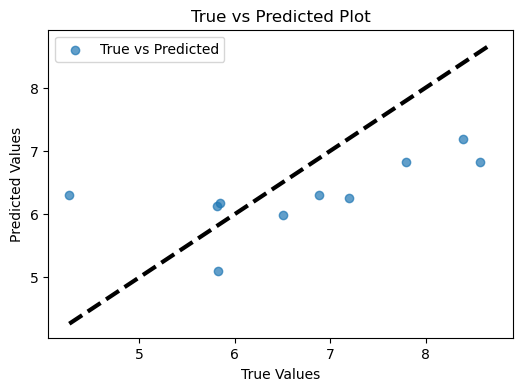

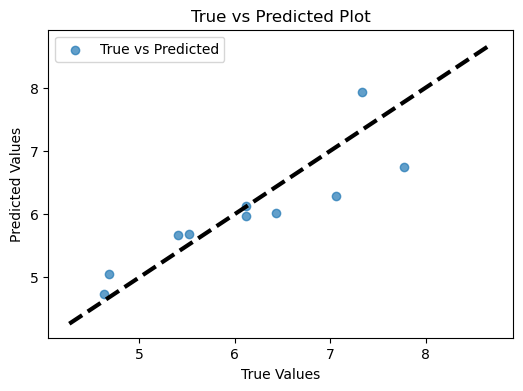

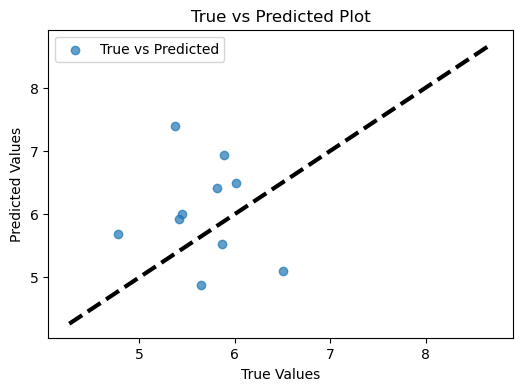

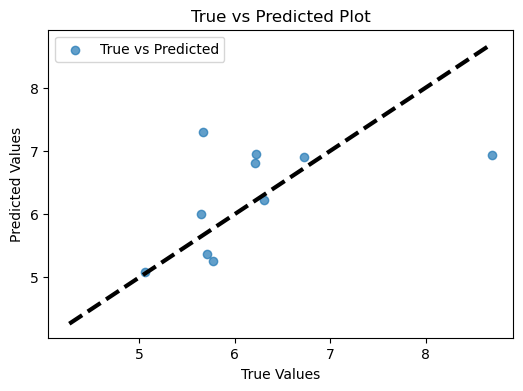

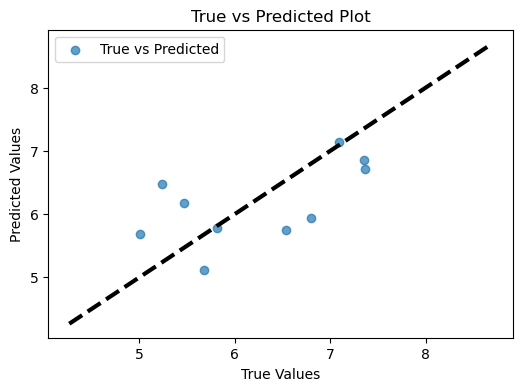

Fold 1: RMSE = 1.08811, R^2 = 0.26493
Fold 2: RMSE = 0.49229, R^2 = 0.76626
Fold 3: RMSE = 0.99387, R^2 = -4.11424
Fold 4: RMSE = 0.84522, R^2 = 0.19132
Fold 5: RMSE = 0.69858, R^2 = 0.33076
Mean RMSE: 0.8236137786205937
Mean R2: -0.5121945637301686
Mean Coefficients: [0.05693043 0.09219918 0.12278635 0.1411507  0.11777707 0.02266398]
Mean Intercept: 4.403509498737824


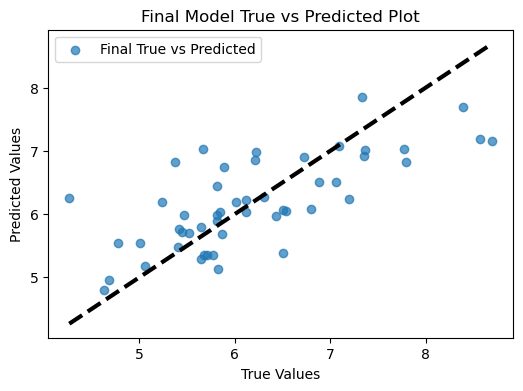

Final Model: RMSE = 0.69699, R^2 = 0.51420


In [48]:
X = inputs_masked[:,1:]
Y = df['Rp-750'].values

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

coefs = []
intercepts = []
rmse = []
r2 = []

df_test_pred = {}

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate RMSE and R^2
    rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_ = r2_score(y_test, y_pred)
    rmse.append(rmse_)
    r2.append(r2_)
    
    # Store coefficients and intercepts
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Plotting true vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7, label='True vs Predicted')
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Plot')
    plt.legend()
    plt.show()

    # Create DataFrame from y_test and y_pred
    df_test_pred['Y_test%s'%i] = y_test
    df_test_pred['Y_pred%s'%i] = y_pred

# Calculate mean of coefficients and intercepts
mean_coef = np.mean(coefs, axis=0)
mean_intercept = np.mean(intercepts)
for i, (rmse_,r2_) in enumerate(zip(rmse,r2)):
    print(f"Fold {i+1}: RMSE = {rmse_:.5f}, R^2 = {r2_:.5f}")

print("Mean RMSE:", np.mean(rmse))
print("Mean R2:", np.mean(r2))
print("Mean Coefficients:", mean_coef)
print("Mean Intercept:", mean_intercept)

# Simulate final model prediction (as a simple matrix operation)
final_predictions = X.dot(mean_coef) + mean_intercept
final_rmse = np.sqrt(mean_squared_error(Y, final_predictions))
final_r2 = r2_score(Y, final_predictions)

# Plot final true vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(Y, final_predictions, alpha=0.7, label='Final True vs Predicted')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Final Model True vs Predicted Plot')
plt.legend()
plt.show()

print(f"Final Model: RMSE = {final_rmse:.5f}, R^2 = {final_r2:.5f}")

df_test_pred = pd.DataFrame(df_test_pred)
df_test_pred.to_excel("test_predictions_splits_noall.xlsx")

# Create DataFrame from y_test and y_pred
df_hybrid = {}
df_hybrid['Y_final'] = final_predictions
df_hybrid['Y'] = Y
df_hybrid = pd.DataFrame(df_hybrid)
df_hybrid.to_excel("test_predictions_hybrid_noall.xlsx")